### Text classification using Tf-Idf 

In [1]:
import json
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_selection import chi2, SelectKBest 

#### Reading a subset from Yelp Dataset

In [2]:
df_b = pd.read_json('yelp_academic_dataset_review.json', lines=True, chunksize=300000)

In [3]:
data=[]
for c in df_b:
    data=c
    break
    

In [4]:
# Shape of the selected data 
data.shape

(300000, 9)

In [5]:
# LAst 5 rows of the data
data.tail()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
299995,0-nk09u6gk4oonzcW4LgMQ,zJfJC--nT-xKLTzdyvroyw,aY-lZvoTHAFl9k6dcfcAxQ,5,0,0,0,Very delicious food and amazing service! I com...,2015-08-12 01:49:19
299996,gJwywVNsIfFlCKiBQj93uw,8nCmV4RMwf4GpaN-A_2Tfw,Khs3iUmkHce7xpAyOo5kRg,3,1,0,0,Sardella's is my favorite pizza chain in the v...,2012-08-23 16:54:00
299997,_0Q9Qg3CZJfuLTtH5KkxbA,nKdhohT1D6doq_v0ReBvzQ,m97jaBYRscg-hqDjMVIIWg,2,0,0,0,The Hostess was the worst. Not very inviting i...,2015-08-24 21:33:18
299998,uc_2Q_UvC0r0AZnERb1k4w,hHuDkGLAOTlR-lLCROotbA,Xs2iTWxbczvfEapAFH3cyw,5,0,1,0,Moved to a new neighborhood = hunt for a new b...,2015-10-23 02:06:21
299999,Q_2ppaCk3go14WNSXUB1Rg,usfq6zK3yG1IA0V5k6XHyQ,mP5qGYKMpy5WWe5BVN5dig,5,1,0,0,This is the best mechanic experience I have ha...,2017-01-07 00:34:54


In [6]:
# Review comment of a random record

data.iloc[3456,7]


"The food has always been good and the service just keeps getting better.  They recently remodeled the building, so it's very modern/clean looking.  They always give you a heaping mound of each dish, so you never feel you're not getting your money's worth.  There's an extra $0.50 or $1.00 for some of the more premium items (shrimp, added bacon, etc) but it's always worth it.  I wouldn't want to eat there every day, but I'm always happy when I get the chance."

Count of different ratings:
  stars
1     41433
2     24493
3     33588
4     68426
5    132060
dtype: int64


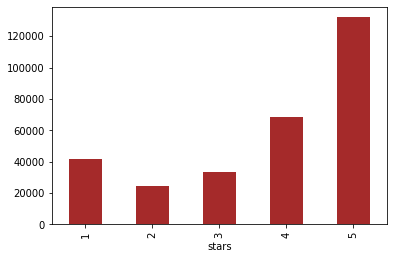

In [7]:

r=data.groupby('stars').size()
print("Count of different ratings:\n ",r)
r.plot.bar(color='brown');

# Data is unbalanced with less records with ratings 2 and 3 and maximum of rating 5

In [8]:
# Balancing the data, considering ratings would be clubbed later on

d1=data[data.stars==1].sample(16794, replace=False)
d2=data[data.stars==2].sample(16794, replace=False)
d3=data[data.stars==3].sample(33588, replace=False)
d4=data[data.stars==4].sample(16794, replace=False)
d5=data[data.stars==5].sample(16794, replace=False)

data=pd.concat([d1,d2,d3,d4,d5])

data.shape

(100764, 9)

In [9]:
pd.options.display.float_format = '{:,.2f}'.format

In [10]:
data.describe()

# Data is categorical, so not much useful info gained apart from the range

,stars,useful,funny,cool
count,"100,764.00","100,764.00","100,764.00","100,764.00"
mean,3.00,1.18,0.43,0.42
std,1.29,2.33,1.41,1.33
min,1.00,0.00,0.00,0.00
25%,2.00,0.00,0.00,0.00
50%,3.00,0.00,0.00,0.00
75%,4.00,1.00,0.00,0.00
max,5.00,76.00,65.00,55.00


#### Pre-processing the Text

In [12]:
# Function to remove the word contractions, like convert isn't to is not
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"ain\'t", "am not", phrase) 
    
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [14]:
# Function to lemmatize - converting a word to its root
def lemmatise(phrase):
    arr=[]
    t=pos_tag(word_tokenize(phrase))
    for a in t:
        postag=get_wordnet_pos(a[1])
        if not postag:
            continue
        p=nltk.stem.WordNetLemmatizer().lemmatize(a[0],pos=postag)
        arr.append(p)
    return arr

In [15]:
# Function to remove stopwords excluding the negations like not, no 

def rem_stopwords(phrase):
    sw=stopwords.words('english')
    sw.remove('no')
    sw.remove('not')
    sw.remove('nor')
    phrase = [word for word in phrase if word not in sw]
    return phrase

In [16]:


def text_cleanup(text):
    
    text= decontracted(text)
    text = re.sub(r'[^\w\s]', '', str(text).lower()) # Regex to remove punctuations and convert to lowercase
    text=lemmatise(text)
    text=rem_stopwords(text)
    text = " ".join(text)
    return text

In [17]:
# Cleaning the text to whole of the dataset
data['text_clean']=data['text'].apply(lambda x: text_cleanup(x))

In [18]:
# Removing all columns except processed text and ratings

data.drop(['review_id','user_id','date','business_id','text','useful','funny','cool'],axis=1,inplace=True);

In [19]:
data.head()

,stars,text_clean
87078,1,give star not make statement racial issue toni...
105130,1,walgreens photo center bad run place third tim...
119744,1,not take bite food already know not back incap...
22667,1,guy really want dollar hour continue mess orde...
165913,1,place awful not know store manager mike mess a...


In [20]:
# Seperating feature and label
X=data.loc[:,'text_clean']
y=data.loc[:,'stars']

In [22]:
# Combining classes with final 3 class of ratings - 0, 1 and 2, not used one hot encoding to maintain ordinality
result = y.replace(to_replace = [1,2], value = 0, inplace=True) 
result = y.replace(to_replace = [4,5], value = 2, inplace=True) 
result = y.replace(to_replace = [3], value = 1, inplace=True) 

In [23]:
# Count of different ratings - data is balanced
y.value_counts()

2    33588
1    33588
0    33588
Name: stars, dtype: int64

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#### Building Model

In [81]:
# using Tf-Idf Vectorizer for creating features and give values to features per document

tfidfv=TfidfVectorizer(min_df=1, max_df=0.5,ngram_range=(1,2),max_features=50000)
X_train_tfidfv = tfidfv.fit_transform(X_train)

In [82]:
#  Taining Reviews are now condensed into 20k features 
print(X_train_tfidfv.shape)

(70534, 50000)


In [84]:
# Using chi square to further reduce no of features
chi2_features = SelectKBest(chi2, k = 30000) 
X_train_kbest_features = chi2_features.fit_transform(X_train_tfidfv, y_train) 

In [85]:
X_train_kbest_features.shape

(70534, 30000)

In [86]:
# training the model

clf = MultinomialNB()
clf.fit(X_train_kbest_features, y_train)

MultinomialNB()

#### Predicting test data 

In [87]:
# Transforming the data through already fitted tfidf object

X_test_tfidfv = tfidfv.transform(X_test)

In [88]:
# Shape of transformed test data
print(X_test_tfidfv.shape)

(30230, 50000)


In [89]:
# Transforming the data through already fitted SelectKbest object
X_test_bestfeatures = chi2_features.transform(X_test_tfidfv) 

In [90]:
# Shape of data after chi square feature selection 

print(X_test_bestfeatures.shape)

(30230, 30000)


In [91]:
# Predicting the test data
y_pred = clf.predict(X_test_bestfeatures)

In [92]:
# Evaluating the model

print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72     10076
           1       0.59      0.67      0.63     10077
           2       0.83      0.73      0.78     10077

    accuracy                           0.71     30230
   macro avg       0.72      0.71      0.71     30230
weighted avg       0.72      0.71      0.71     30230



In [93]:
# Total number of predictions across each class
np.unique(y_pred,return_counts=True)

(array([0, 1, 2], dtype=int64), array([ 9806, 11519,  8905], dtype=int64))

##### Analysing and classifying a single review 

In [94]:
string="'ABSOLUTELY HORRIFIC. We waited 15 minutes just to get water, OVER 20 for soy sauce (which we never got) spent 60$ for 3 disgusting rolls. Save your money, we were excited for sushi in Vegas. I would have rather spent 60 gambling and lost it all. This place should be out of business already.'"

str_clean=(text_cleanup(string))

In [95]:
print("Text after processing:\n ",(str_clean))

Text after processing:
  absolutely horrific wait minute get water soy sauce never get spent disgust roll save money excite sushi vega rather spend gambling lose place business already


In [96]:
# Transforming the text using tfidf vectorizer
str_tfidf = tfidfv.transform([str_clean])

In [97]:
# Selecting best features using SelectKbest
str_best_features = chi2_features.transform(str_tfidf) 

In [98]:
# Selecting list of K best features
mask = chi2_features.get_support()
new_features = [] 

for bool, feature in zip(mask, tfidfv.get_feature_names()):
    if bool:
        new_features.append(feature)
 
# Creating a Dataframe with tfidf values against K best features
        
fr=pd.DataFrame(str_best_features.toarray(),columns=new_features)
fr=fr.transpose()



In [99]:
# Displaying list of values assigned to features in descending order specific to the review
fr[fr[0]>0].sort_values(by=[0], ascending=False)

# Keywords like horrific,disgust got good values, but not for example wait. Likewise few bigrams like 'never get' is good but few like absolutely horrific wasn't in features 

,0
place business,0.26
rather spend,0.26
gambling,0.25
horrific,0.25
get water,0.22
soy sauce,0.22
spent,0.22
save money,0.20
soy,0.20
never get,0.19


In [100]:
# Predicting the rating for the review
y_pred = clf.predict(str_best_features)
print(y_pred)

# Value predicted correctly, 0 is for a bad review

[0]


#### Conclusion

Multi-class Text classification using basic bag of words approach and basic MultinomialNB gives overall accuracy of around 0.7. 